In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

1. Extraire des infos intéressants

In [3]:
ticket = pd.read_csv('/content/drive/MyDrive/data/exercise_stage/ticket_data.csv')

In [4]:
Prix = ticket.groupby(['o_city', 'd_city'])['price_in_cents'].agg([np.min, np.max, np.mean])
Prix

amin   amax          mean
o_city d_city                            
5      23      18600  22000  20320.000000
6      227      9860  13650  11755.000000
       504      2000   8920   4042.666667
       628      2600   3190   2797.500000
       845       700   2420    864.626866
...              ...    ...           ...
11938  126      3000   5350   4204.861111
12124  1064     6000   7900   6950.000000
12166  857      5300   5300   5300.000000
12190  639       600    850    688.888889
       8937     9800   9800   9800.000000

[1437 rows x 3 columns]

In [5]:
Prix.loc[(6,227)]

amin     9860.0
amax    13650.0
mean    11755.0
Name: (6, 227), dtype: float64

In [6]:
ticket['time'] = pd.to_datetime(ticket['arrival_ts']) - pd.to_datetime(ticket['departure_ts'])
Time = ticket.groupby(['o_city', 'd_city'])['time'].agg([np.min, np.max, np.mean])
Time

amin            amax                      mean
o_city d_city                                                          
5      23     0 days 08:53:00 0 days 15:54:00           0 days 10:18:48
6      227    0 days 12:24:00 0 days 15:01:00           0 days 13:42:30
       504    0 days 05:36:00 0 days 12:20:00           0 days 08:17:24
       628    0 days 09:40:00 0 days 14:30:00           0 days 12:10:00
       845    0 days 01:00:00 0 days 04:11:00 0 days 01:19:54.626865671
...                       ...             ...                       ...
11938  126    0 days 05:30:00 1 days 11:20:00 0 days 07:25:16.666666666
12124  1064   0 days 11:10:00 0 days 23:10:00           0 days 17:10:00
12166  857    0 days 21:55:00 0 days 21:55:00           0 days 21:55:00
12190  639    0 days 01:10:00 0 days 02:40:00 0 days 01:28:53.333333333
       8937   0 days 09:10:00 0 days 09:10:00           0 days 09:10:00

[1437 rows x 3 columns]

In [7]:
Time.loc[(6,227)]

amin   0 days 12:24:00
amax   0 days 15:01:00
mean   0 days 13:42:30
Name: (6, 227), dtype: timedelta64[ns]

2 La distance

In [8]:
pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from haversine import haversine

In [10]:
cities = pd.read_csv('/content/drive/MyDrive/data/exercise_stage/cities.csv')

In [11]:
cities = cities.rename(columns={'id':'id_city'})
ticket = ticket.rename(columns={'id':'id_ticket'})

In [12]:
ticket_cities = pd.merge(ticket, cities, left_on='o_city', right_on='id_city', how='inner')
ticket_cities = pd.merge(ticket_cities, cities, left_on='d_city', right_on='id_city', how='inner')

In [13]:
# ticket_cities.dtypes

In [14]:
def get_distance(x):
  lat1 = x['latitude_x']
  lon1 = x['longitude_x']
  lat2 = x['latitude_y']
  lon2 = x['longitude_y']
  return round(haversine((lat1, lon1),(lat2, lon2)),3)


In [15]:
ticket_cities.loc[:,'distance'] = ticket_cities.apply(get_distance, axis=1)

In [16]:
# ticket_cities.head()

In [17]:
providers = pd.read_csv('/content/drive/MyDrive/data/exercise_stage/providers.csv')

In [18]:
providers = providers.rename(columns={'id':'id_provider'})
# providers.dtypes

In [19]:
ticket_cities_providers = pd.merge(ticket_cities, providers, left_on='company', right_on='id_provider', how='inner')
# ticket_cities_providers.dtypes

In [20]:
D200 = ticket_cities_providers.loc[ticket_cities_providers['distance']<200, :]
D200.groupby('transport_type').agg({'price_in_cents':np.mean, 'time':np.mean})

,price_in_cents,time
transport_type,,
bus,2182.830918,0 days 10:13:57.053140096
carpooling,1177.352385,0 days 01:57:07.342427561
train,3487.900779,0 days 04:25:09.840098400


In [21]:
D800 = ticket_cities_providers.loc[(ticket_cities_providers['distance']>200)& (ticket_cities_providers['distance']<800), :]
D800.groupby('transport_type').agg({'price_in_cents':np.mean, 'time':np.mean})

,price_in_cents,time
transport_type,,
bus,3494.850022,0 days 15:04:29.269314709
carpooling,3218.064310,0 days 04:45:47.272436410
train,9124.779489,0 days 07:40:39.543514566


In [22]:
D2000 = ticket_cities_providers.loc[(ticket_cities_providers['distance']>800)& (ticket_cities_providers['distance']<2000), :]
D2000.groupby('transport_type').agg({'price_in_cents':np.mean, 'time':np.mean})

,price_in_cents,time
transport_type,,
bus,6949.950045,1 days 03:32:10.027247956
carpooling,8626.545455,0 days 13:06:00.839160839
train,15463.746130,0 days 12:09:31.021671826


In [23]:
# ticket_cities_providers

BONUS

In [24]:
short = ticket_cities_providers.copy()
# short.dtypes

In [25]:
short = short.loc[:,['id_ticket','company','price_in_cents','time','distance','transport_type']]
# short

In [26]:
short.loc[:, 'time'] = short['time'] / np.timedelta64(1,'m')

In [27]:
short['velocity'] = short['distance'] /short['time'] * 60
short['price_distance'] = short['price_in_cents'] / short['distance']

In [28]:
# short

In [29]:
short.groupby('transport_type').agg({'velocity':np.mean, 'price_distance':np.mean})

,velocity,price_distance
transport_type,,
bus,35.772984,9.203141
carpooling,75.038035,8.907696
train,75.572234,22.380288


In [30]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'La price par kilometre de differents longeurs')

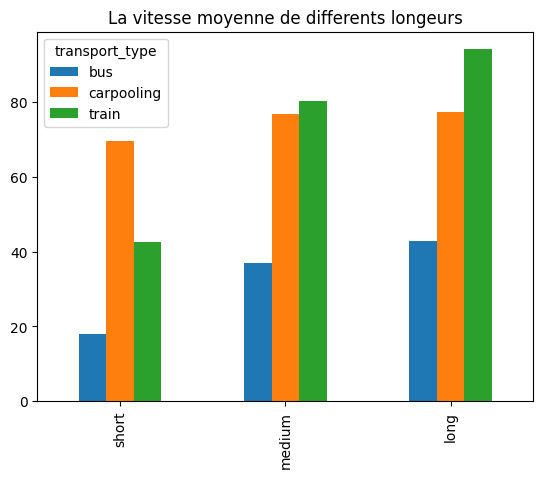

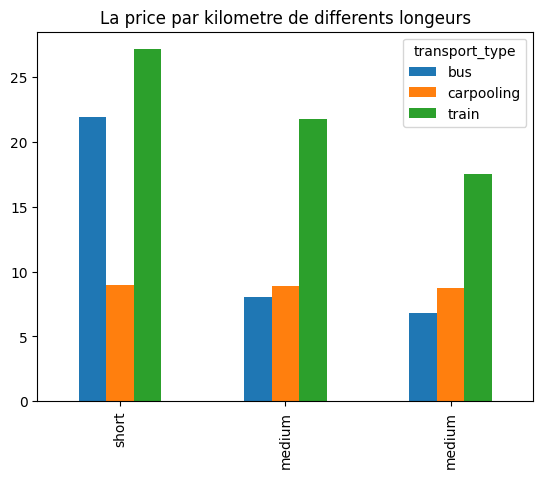

In [31]:
s200 = short.loc[short['distance']<200, :]
v200 = s200.groupby('transport_type')['velocity'].agg(np.mean).rename('short')
p200 = s200.groupby('transport_type')['price_distance'].agg(np.mean).rename('short')

s800 = short.loc[(short['distance']>200) & (short['distance']<800), :]
v800 = s800.groupby('transport_type')['velocity'].agg(np.mean).rename('medium')
p800 = s800.groupby('transport_type')['price_distance'].agg(np.mean).rename('medium')

s2000 = short.loc[(short['distance']>800) & (short['distance']<2000), :]
v2000 = s2000.groupby('transport_type')['velocity'].agg(np.mean).rename('long')
p2000 = s2000.groupby('transport_type')['price_distance'].agg(np.mean).rename('medium')

velocity = pd.concat([v200,v800,v2000], axis=1)
velocity.T.plot.bar()
plt.title('La vitesse moyenne de differents longeurs')
price_distance = pd.concat([p200,p800,p2000], axis=1)
price_distance.T.plot.bar()
plt.title('La price par kilometre de differents longeurs')

# print(s200.groupby('transport_type').agg({'velocity':np.mean, 'price_distance':np.mean}),'\n',
#    s800.groupby('transport_type').agg({'velocity':np.mean, 'price_distance':np.mean}),'\n',
#    s2000.groupby('transport_type').agg({'velocity':np.mean, 'price_distance':np.mean}))

In [34]:
import matplotlib.ticker as ticker

In [32]:
from pandas.core.dtypes.dtypes import CategoricalDtype
def prediction(depart,destination,date,transport):
  ticket_cities = pd.merge(ticket, cities, left_on='o_city', right_on='id_city', how='inner')
  ticket_cities = pd.merge(ticket_cities, cities, left_on='d_city', right_on='id_city', how='inner')
  ticket_cities_providers = pd.merge(ticket_cities, providers, left_on='company', right_on='id_provider', how='inner')

  city = ticket_cities_providers.copy()
  city = city.loc[:,['id_ticket','price_in_cents','departure_ts','search_ts','o_city','d_city','transport_type']]
  city = city[city['departure_ts'].str.startswith(date)] # input the date

  city = city.loc[(city['o_city']==depart) & (city['d_city']==destination) & (city['transport_type']==transport) ] #input the depart,destination and type of transport
  # print(city.shape)
  if city.shape[0] == 0:
    print('No such trajet !!!')
    return 

  city['price_average'] = city.departure_ts.map(city.groupby(['departure_ts']).price_in_cents.mean())

  city = city.drop_duplicates('price_average',keep='first')
  city = city.set_index('departure_ts')
  city = city.sort_values(by='departure_ts')

  fig = city['price_average'].plot()
  fig.xaxis.set_major_locator(ticker.MultipleLocator(base=1))
  plt.xticks(rotation = 45) 
  plt.show()


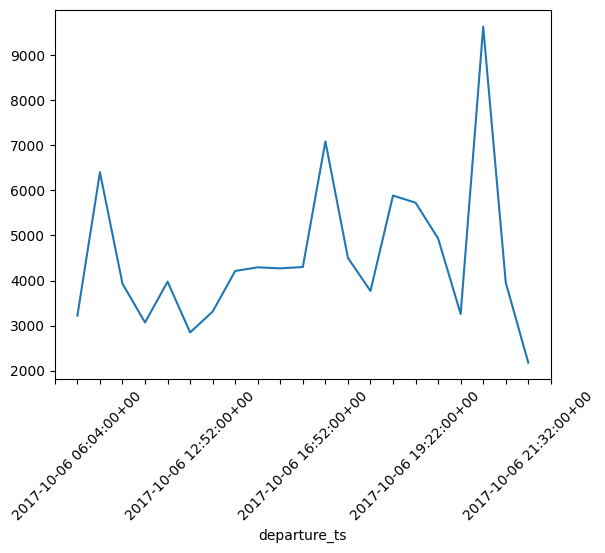

In [35]:
prediction(628,453,'2017-10-06','train')

Le prix de train depart de paris 628

In [36]:
ticket_cities = pd.merge(ticket, cities, left_on='o_city', right_on='id_city', how='inner')
ticket_cities = pd.merge(ticket_cities, cities, left_on='d_city', right_on='id_city', how='inner')
ticket_cities_providers = pd.merge(ticket_cities, providers, left_on='company', right_on='id_provider', how='inner')

paris = ticket_cities_providers.copy()
# paris.dtypes

In [37]:
paris = paris.loc[:,['id_ticket','price_in_cents','departure_ts','search_ts','o_city','d_city','transport_type']]

In [38]:
paris = paris[paris['departure_ts'].str.startswith('2017-10-06')]

In [39]:
paris = paris.loc[(paris['o_city']==628) & (paris['d_city']==453) & (paris['transport_type']=='train') ]
paris['price_average'] = paris.departure_ts.map(paris.groupby(['departure_ts']).price_in_cents.mean())

In [40]:
# paris

In [41]:
paris = paris.drop_duplicates('price_average',keep='first')

In [42]:
paris = paris.set_index('departure_ts')
paris = paris.sort_values(by='departure_ts')
paris

,id_ticket,price_in_cents,search_ts,o_city,d_city,transport_type,price_average
departure_ts,,,,,,,
2017-10-06 06:04:00+00,6795084,3220,2017-10-01 01:04:35.34+00,628,453,train,3220.000000
2017-10-06 07:51:00+00,6810712,5300,2017-10-05 17:05:12.352+00,628,453,train,6400.000000
2017-10-06 07:52:00+00,6795086,3150,2017-10-01 01:04:35.34+00,628,453,train,3929.166667
2017-10-06 08:34:00+00,6795087,3070,2017-10-01 01:04:35.34+00,628,453,train,3070.000000
2017-10-06 10:52:00+00,6795088,3150,2017-10-01 01:04:35.341+00,628,453,train,3975.000000
2017-10-06 12:52:00+00,6795085,2850,2017-10-01 01:04:35.342+00,628,453,train,2850.000000
2017-10-06 14:04:00+00,6795089,3220,2017-10-01 01:04:35.342+00,628,453,train,3311.666667
2017-10-06 14:52:00+00,6795093,4350,2017-10-01 01:04:35.342+00,628,453,train,4212.500000
2017-10-06 16:04:00+00,6805545,4120,2017-10-04 14:52:14.663+00,628,453,train,4292.727273


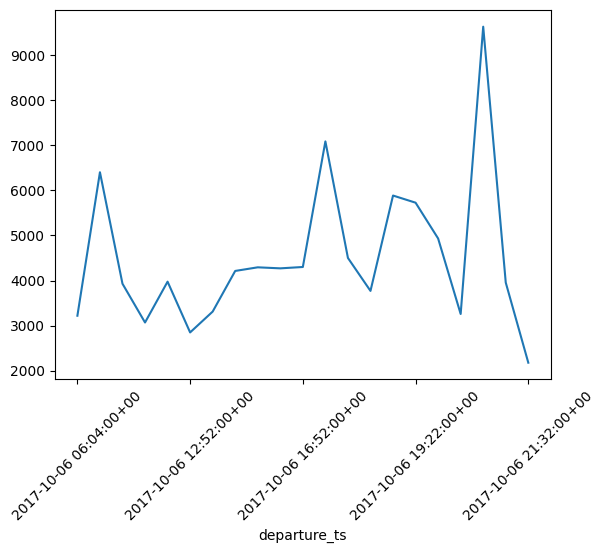

In [43]:
import matplotlib.ticker as ticker
fig = paris['price_average'].plot()
fig.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
plt.xticks(rotation = 45) 
plt.show()